# Allen Institute Visual Behavior 2P dataset overview
### This dataset consists of neural activity measured with 2-photon calcium imaging in the visual cortex of mice performing an image change detection task.
##### In this task, mice learn to report changes in stimulus identity by licking a spout to earn a water reward.


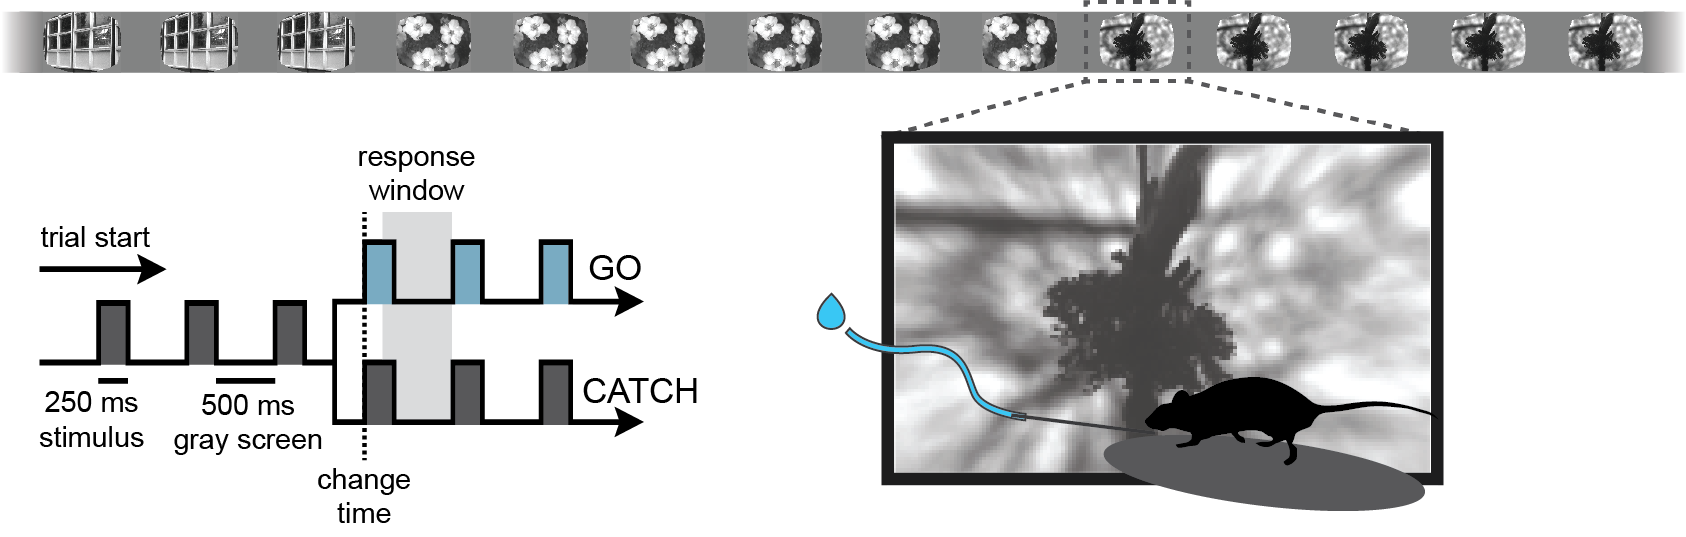

##### In some sessions, the mice perform the task with familiar images they have seen many times during training. In other sessions, mice perform the task with novel images.
##### During 2-photon imaging sessions, 5% of stimulus presentations are randomly omitted, allowing us to examine the effect of unexpected events on neural activity.
##### The same population of cells is imaged over multiple days with varying sensory and behavioral conditions.


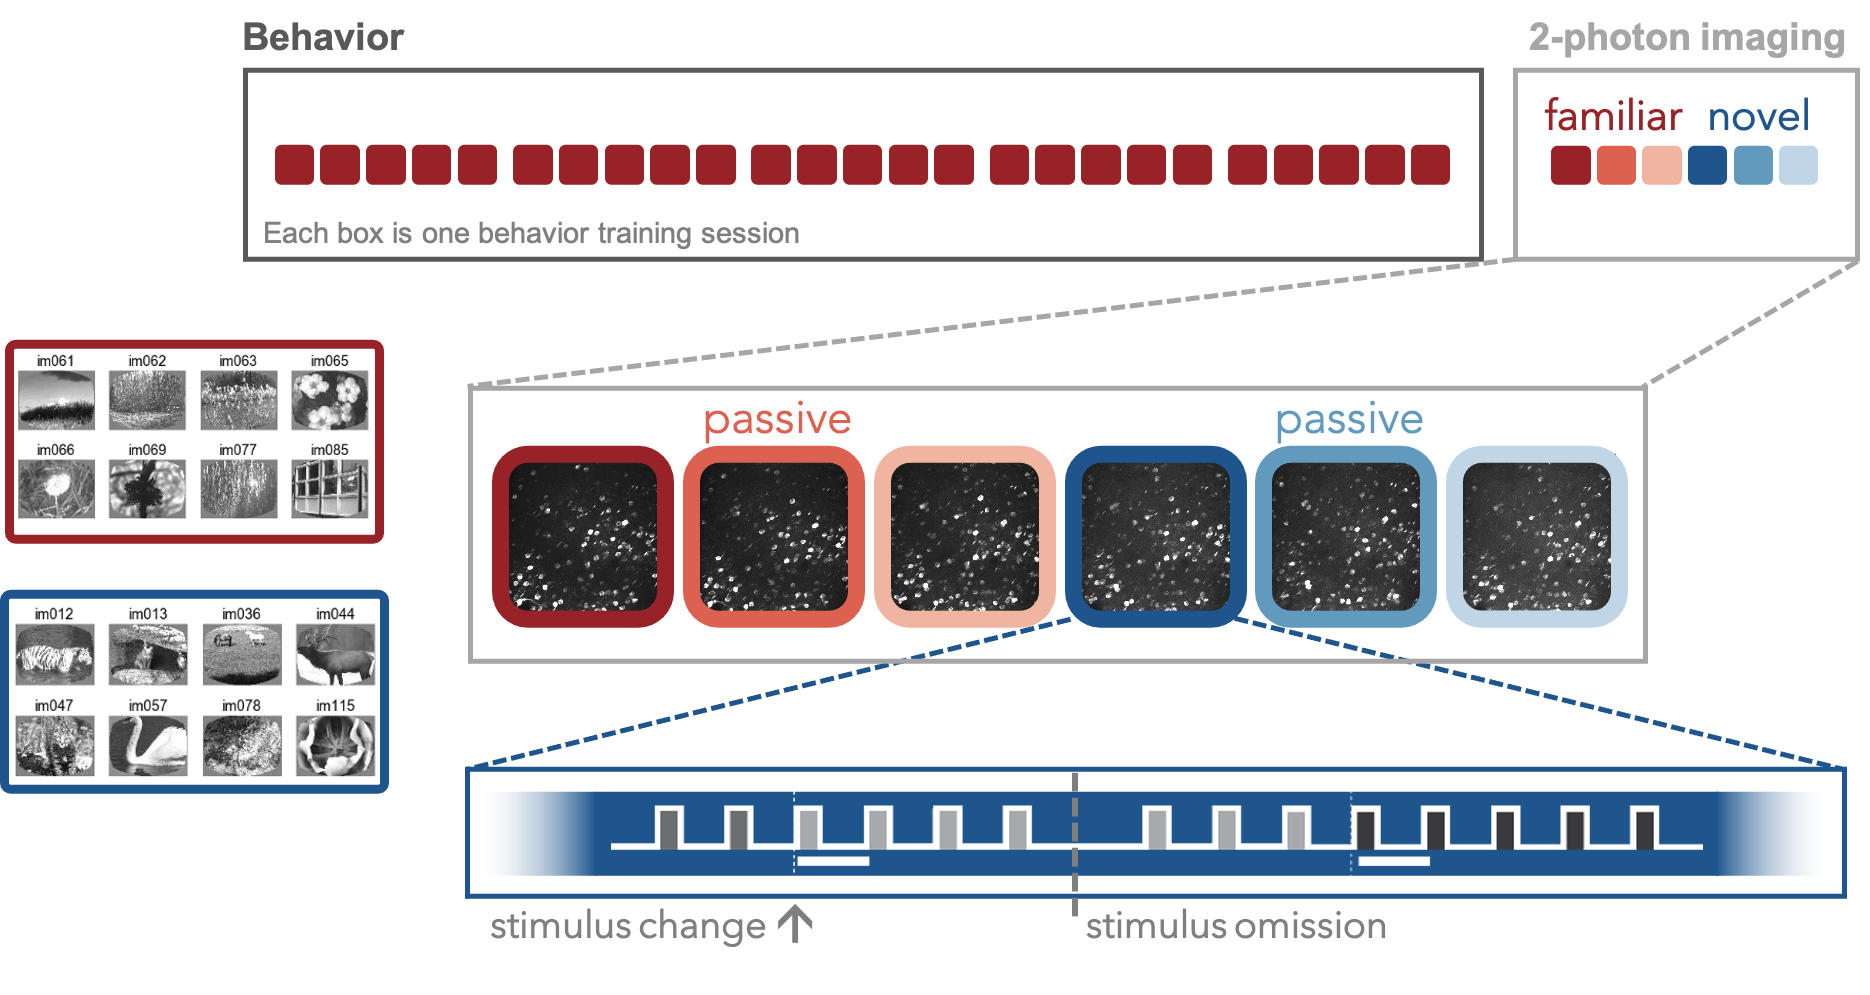

##### Multiple cortical areas and depths were measured concurently in each session, at a sample rate of 11Hz.
##### Data was collected from excitatory and inhibitory neural populations.

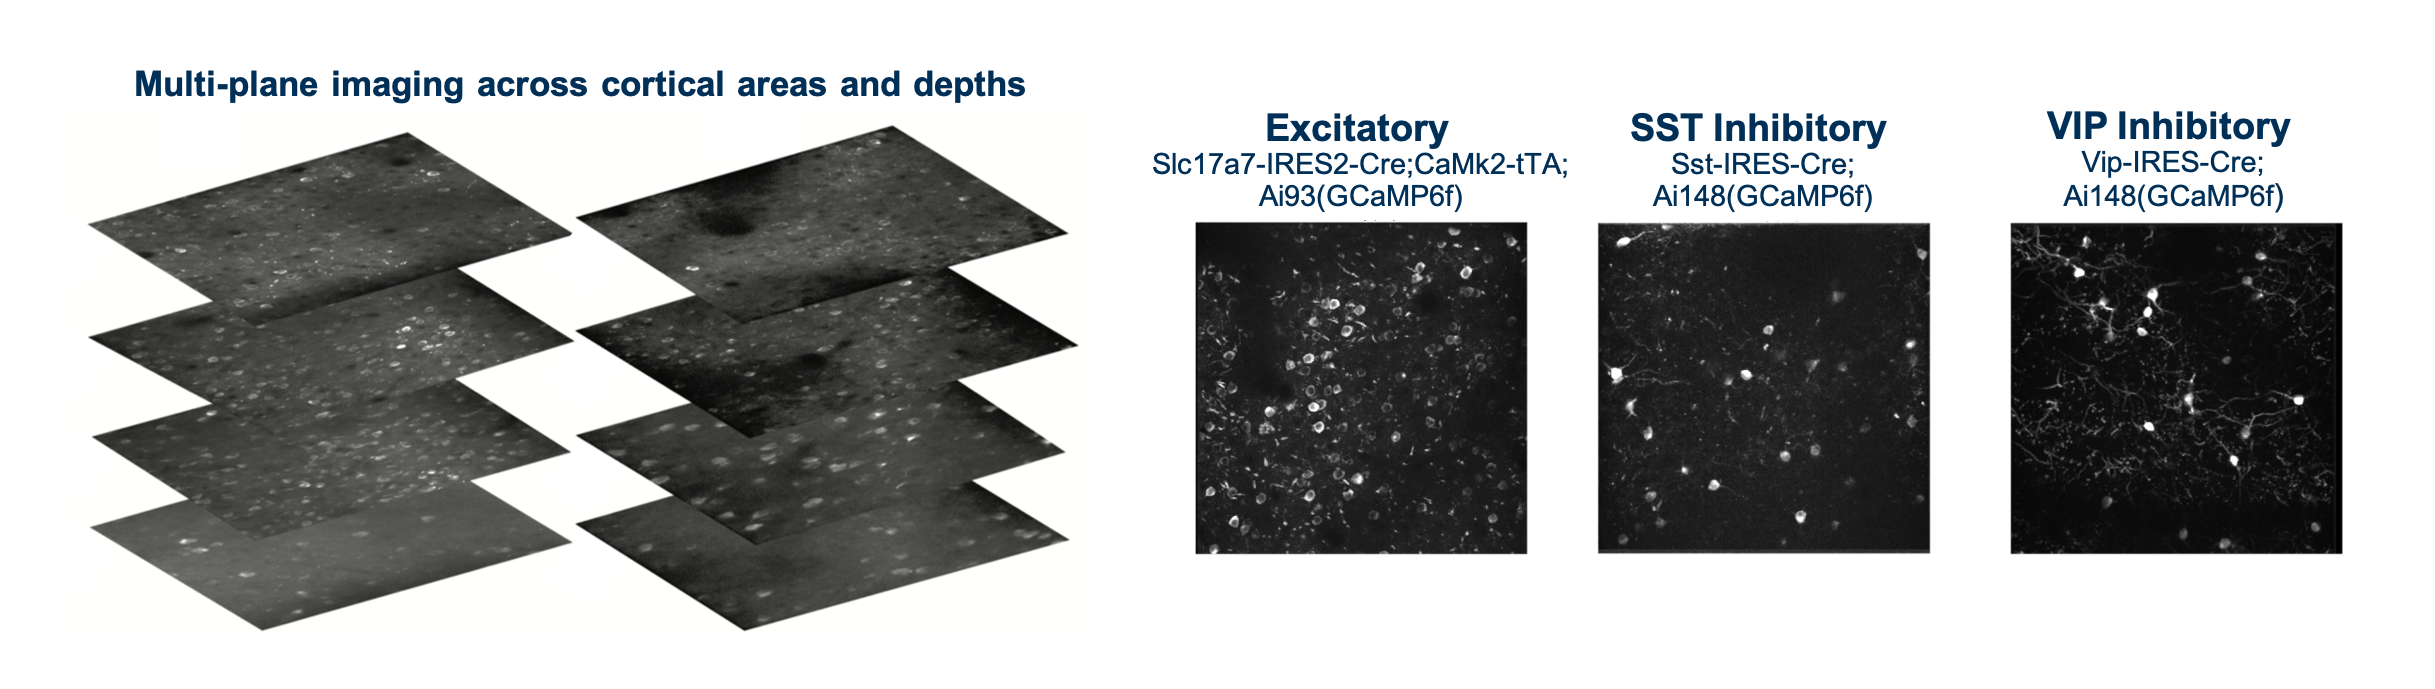

#### You can learn more about this dataset, behavioral task, and find other useful tools here:
#### [Overview page](https://allenswdb.github.io/physiology/ophys/visual-behavior/VB-Ophys.html) and [Allen Brain Atlas](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)
#### This example will focus on the activity of the two inhibitory types - VIP and SST neurons.

# Loading the data

In [1]:
# @title Install dependencies

!pip install pandas --quiet
!pip install seaborn --quiet
!pip install  pyarrow # may be needed to read data file

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [3]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [4]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

#### The data is organized as a pandas dataframe.
#### Each row contains all data for a given cell on a given trial


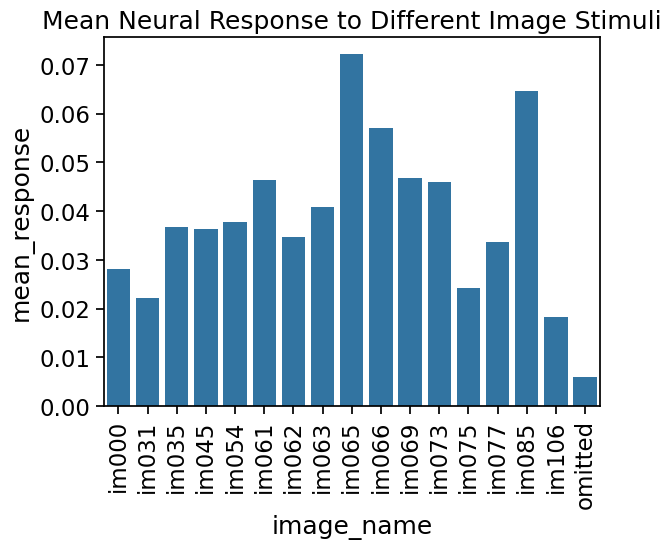

In [6]:
#How does the neural response vary for different image stimuli?
# Group by image name and calculate the mean response
mean_responses = data.groupby('image_name')['mean_response'].mean().reset_index()

# Plot the mean responses
sns.barplot(data=mean_responses, x='image_name', y='mean_response')
plt.xticks(rotation=90)
plt.title('Mean Neural Response to Different Image Stimuli')
plt.show()


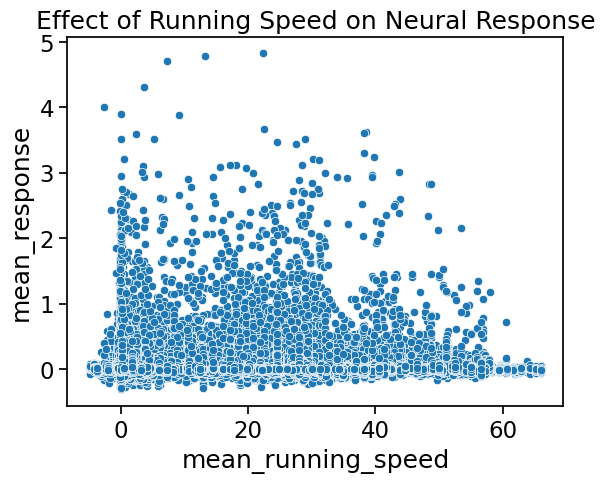

Correlation between running speed and neural response: 0.07308467512891939


In [7]:
#Does the running speed of the mouse affect its neural response?
sns.scatterplot(data=data, x='mean_running_speed', y='mean_response')
plt.title('Effect of Running Speed on Neural Response')
plt.show()

# correlation
correlation = data['mean_running_speed'].corr(data['mean_response'])
print(f'Correlation between running speed and neural response: {correlation}')

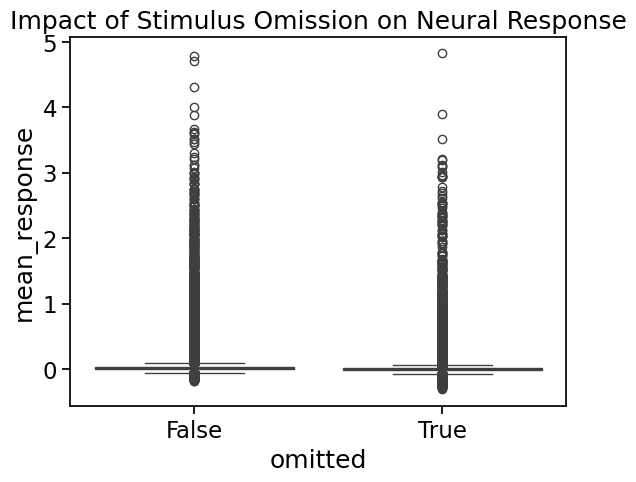

T-test results: t-statistic = -43.09493084486097, p-value = 0.0


In [8]:
#What is the effect of stimulus omission on neural activity?
# Box plot for omitted vs. non-omitted stimuli
sns.boxplot(data=data, x='omitted', y='mean_response')
plt.title('Impact of Stimulus Omission on Neural Response')
plt.show()

# t-test
from scipy.stats import ttest_ind

omitted_responses = data[data['omitted'] == True]['mean_response']
non_omitted_responses = data[data['omitted'] == False]['mean_response']
t_stat, p_value = ttest_ind(omitted_responses, non_omitted_responses)
print(f'T-test results: t-statistic = {t_stat}, p-value = {p_value}')

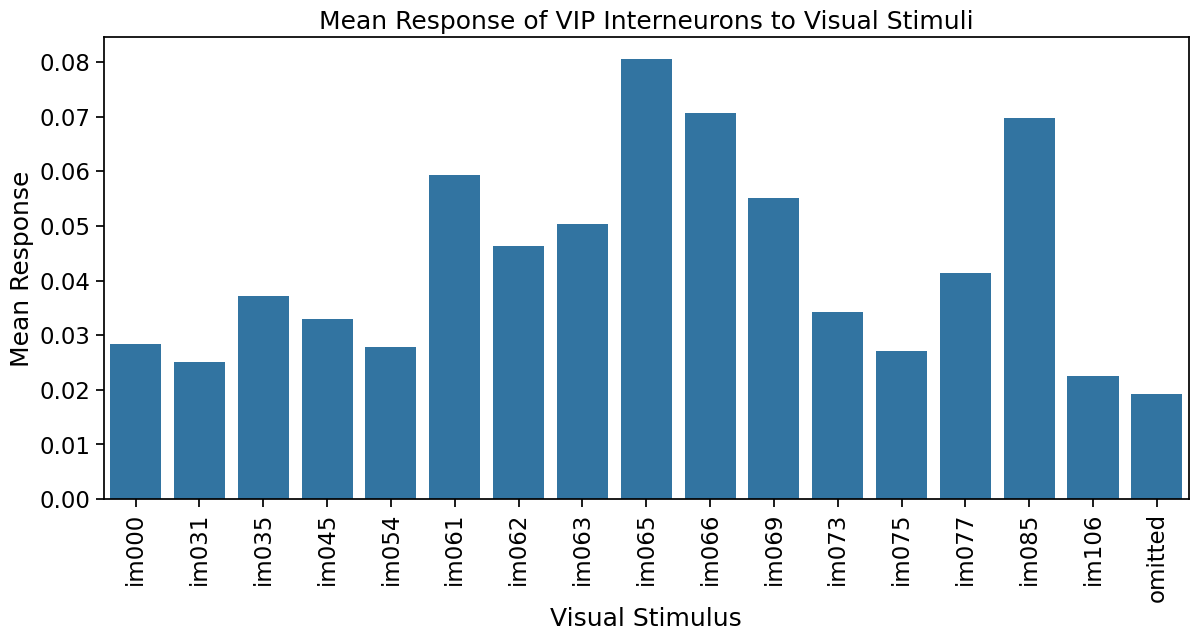

In [9]:
#Relationship between VIP Interneurons and Visual Stimulus Responses
# Filter data for VIP interneurons
vip_data = data[data['cre_line'] == 'Vip-IRES-Cre']

# Group by image_name and calculate mean response for each stimulus
mean_responses = vip_data.groupby('image_name')['mean_response'].mean().reset_index()

# Plot the mean responses for each stimulus
plt.figure(figsize=(14, 6))
sns.barplot(data=mean_responses, x='image_name', y='mean_response')
plt.xticks(rotation=90)
plt.xlabel('Visual Stimulus')
plt.ylabel('Mean Response')
plt.title('Mean Response of VIP Interneurons to Visual Stimuli')
plt.show()

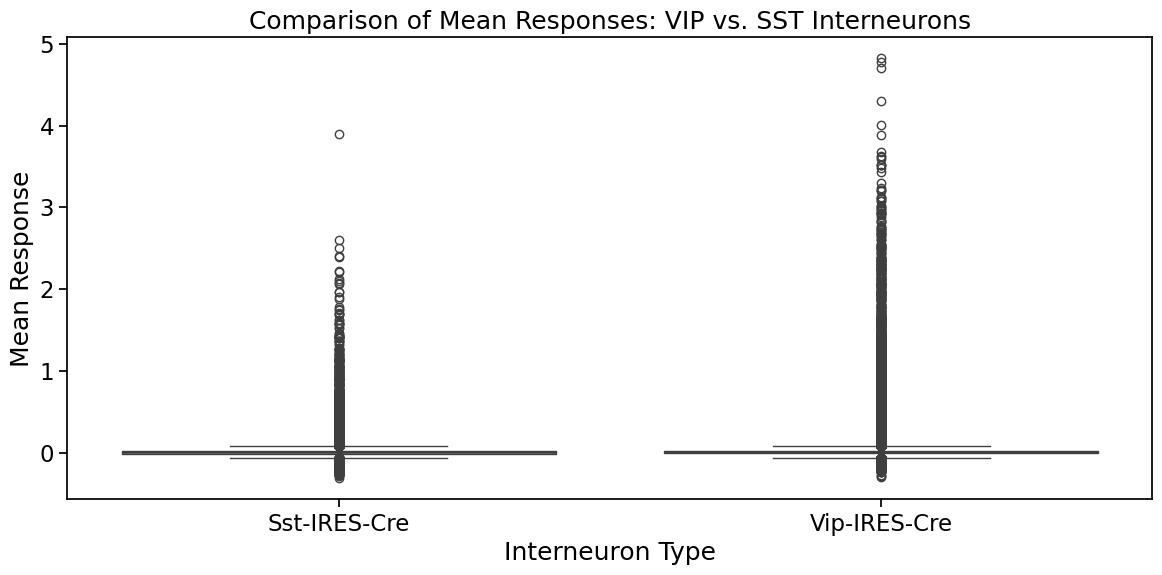

In [12]:
#comparison of VIP and SST Interneuron Activity
# Filter data for VIP and SST interneurons
sst_data = data[data['cre_line'] == 'Sst-IRES-Cre']

# Compare mean responses
plt.figure(figsize=(14, 6))
sns.boxplot(data=data[data['cre_line'].isin(['Vip-IRES-Cre', 'Sst-IRES-Cre'])], x='cre_line', y='mean_response')
plt.xlabel('Interneuron Type')
plt.ylabel('Mean Response')
plt.title('Comparison of Mean Responses: VIP vs. SST Interneurons')
plt.show()

In [13]:
#Correlation of VIP Activity with Suppression of SST Interneurons

vip_mean_response = vip_data['mean_response'].mean()
sst_mean_response = sst_data['mean_response'].mean()

# Calculate Pearson correlation
correlation = vip_data['mean_response'].corr(sst_data['mean_response'])
print(f'Correlation between VIP and SST interneurons: {correlation}')

Correlation between VIP and SST interneurons: nan


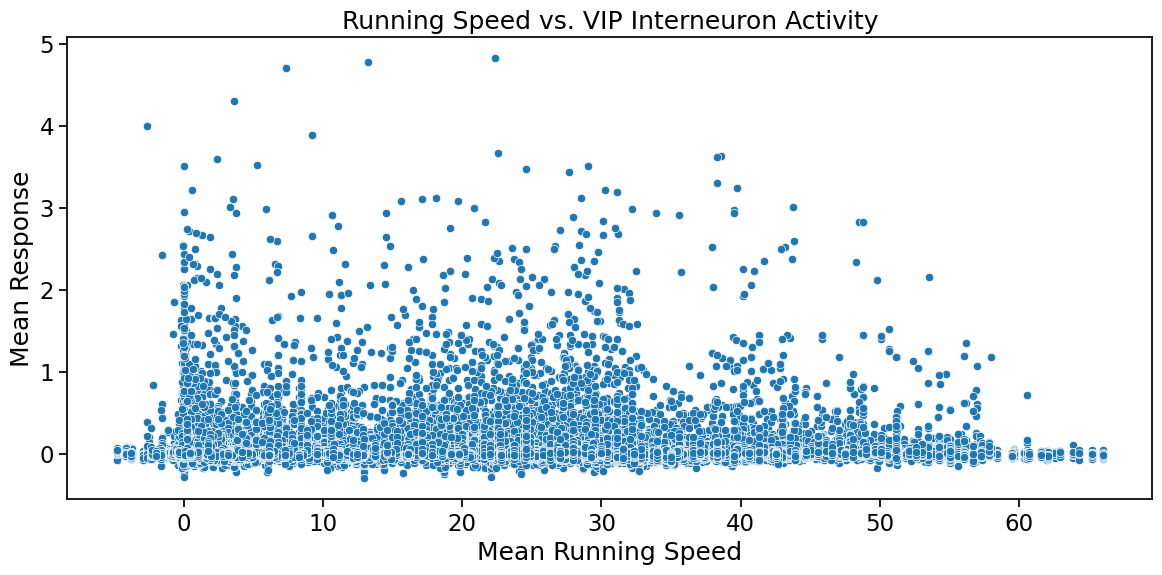

In [14]:
#Effect of Locomotion on VIP Neuron Activity
# Plot running speed vs. mean response for VIP interneurons
plt.figure(figsize=(14, 6))
sns.scatterplot(data=vip_data, x='mean_running_speed', y='mean_response')
plt.xlabel('Mean Running Speed')
plt.ylabel('Mean Response')
plt.title('Running Speed vs. VIP Interneuron Activity')
plt.show()

<ipython-input-15-a5771cf56190>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vip_data['is_locomotion'] = vip_data['mean_running_speed'] > locomotion_threshold


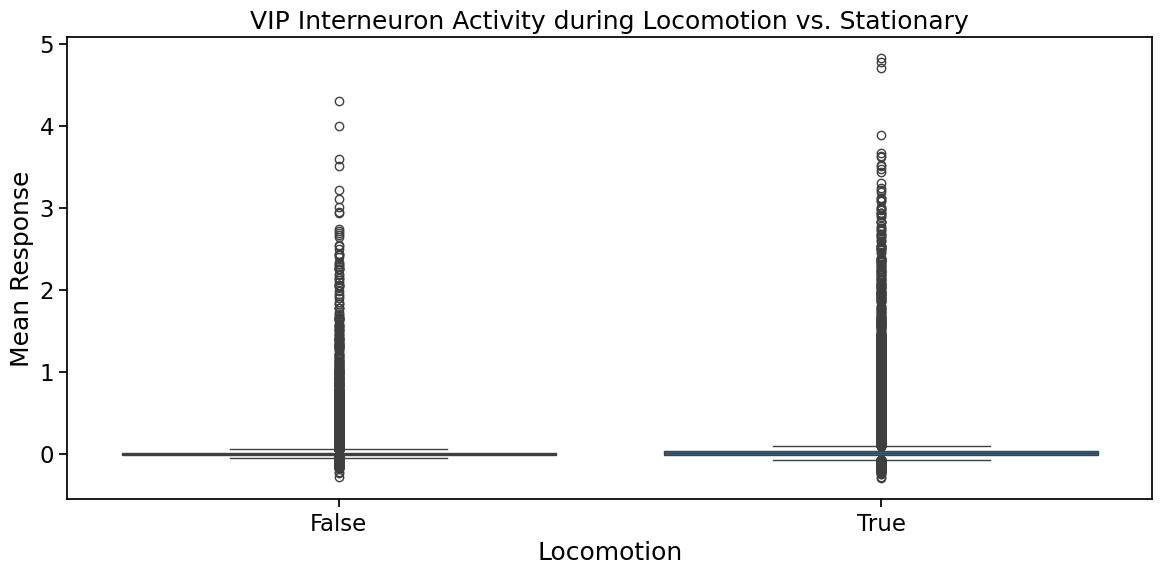

In [15]:
#Enhanced Responses during Locomotion
locomotion_threshold = 5  # Define a threshold for locomotion
vip_data['is_locomotion'] = vip_data['mean_running_speed'] > locomotion_threshold

plt.figure(figsize=(14, 6))
sns.boxplot(data=vip_data, x='is_locomotion', y='mean_response')
plt.xlabel('Locomotion')
plt.ylabel('Mean Response')
plt.title('VIP Interneuron Activity during Locomotion vs. Stationary')
plt.show()

In [17]:
data.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response', 'image_name',
       'image_index', 'is_change', 'omitted', 'mean_running_speed',
       'mean_pupil_area', 'response_latency', 'rewarded',
       'ophys_experiment_id', 'imaging_depth', 'targeted_structure',
       'cre_line', 'session_type', 'session_number', 'mouse_id',
       'ophys_session_id', 'ophys_container_id', 'behavior_session_id',
       'full_genotype', 'reporter_line', 'driver_line', 'indicator', 'sex',
       'age_in_days', 'exposure_level'],
      dtype='object')

T-test results: t-statistic = 102.03755622745574, p-value = 0.0


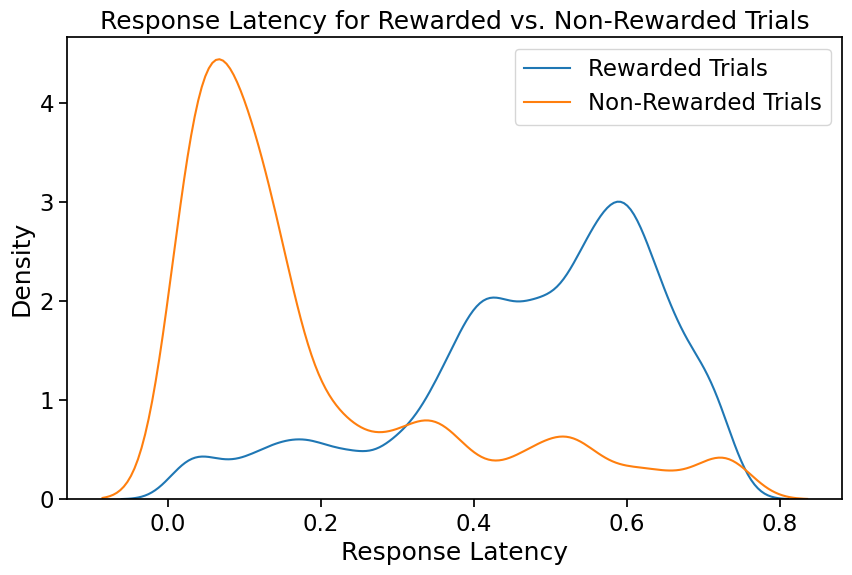

In [24]:
# Separate data for rewarded and non-rewarded trials
rewarded_trials = vip_data[vip_data['rewarded'] == True]
non_rewarded_trials = vip_data[vip_data['rewarded'] == False]

# Calculate mean response latency
response_latency_rewarded = rewarded_trials['response_latency'].dropna()
response_latency_non_rewarded = non_rewarded_trials['response_latency'].dropna()

# Perform t-test
t_stat, p_value = ttest_ind(response_latency_rewarded, response_latency_non_rewarded)
print(f'T-test results: t-statistic = {t_stat}, p-value = {p_value}')

# Plot the results
plt.figure(figsize=(10, 6))
sns.kdeplot(response_latency_rewarded, label='Rewarded Trials')
sns.kdeplot(response_latency_non_rewarded, label='Non-Rewarded Trials')
plt.xlabel('Response Latency')
plt.ylabel('Density')
plt.title('Response Latency for Rewarded vs. Non-Rewarded Trials')
plt.legend()
plt.show()


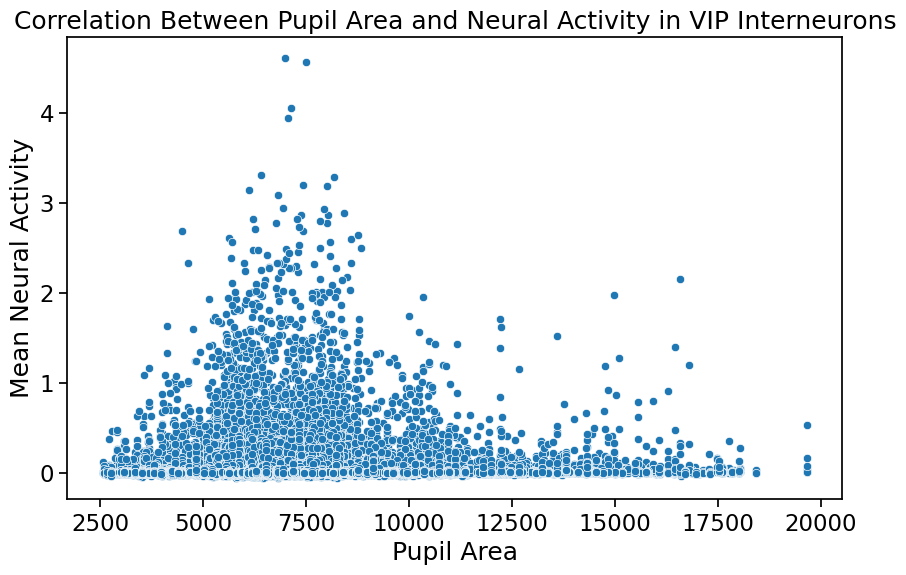

In [26]:
# Calculate mean pupil area and corresponding neural activity
pupil_area = vip_data['mean_pupil_area']
mean_trace = vip_data['trace'].apply(np.mean)

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pupil_area, y=mean_trace)
plt.xlabel('Pupil Area')
plt.ylabel('Mean Neural Activity')
plt.title('Correlation Between Pupil Area and Neural Activity in VIP Interneurons')
plt.show()

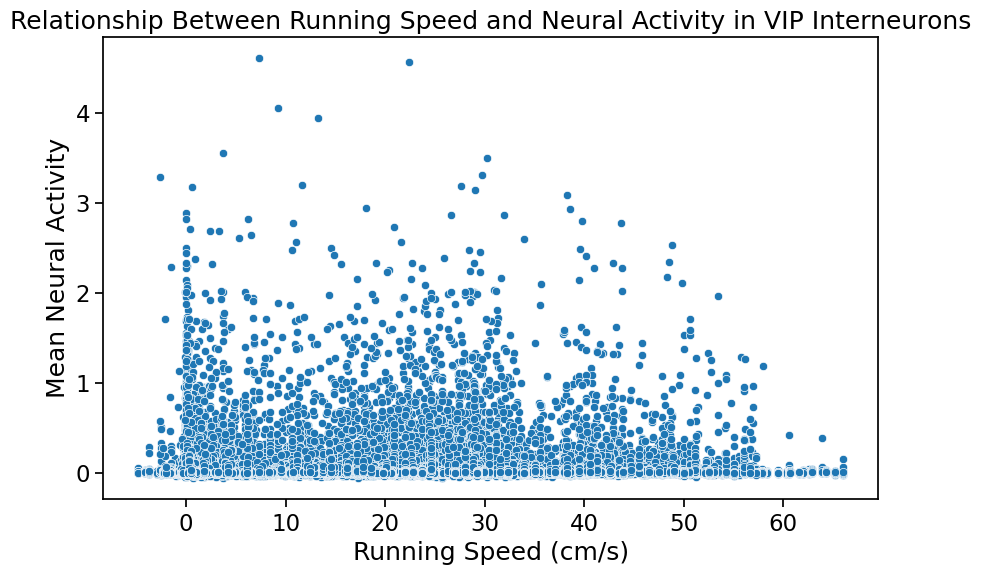

In [27]:
# Calculate mean running speed and corresponding neural activity
running_speed = vip_data['mean_running_speed']
mean_trace = vip_data['trace'].apply(np.mean)

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=running_speed, y=mean_trace)
plt.xlabel('Running Speed (cm/s)')
plt.ylabel('Mean Neural Activity')
plt.title('Relationship Between Running Speed and Neural Activity in VIP Interneurons')
plt.show()

Exposure level counts:
 exposure_level
familiar    93352
novel       54343
Name: count, dtype: int64


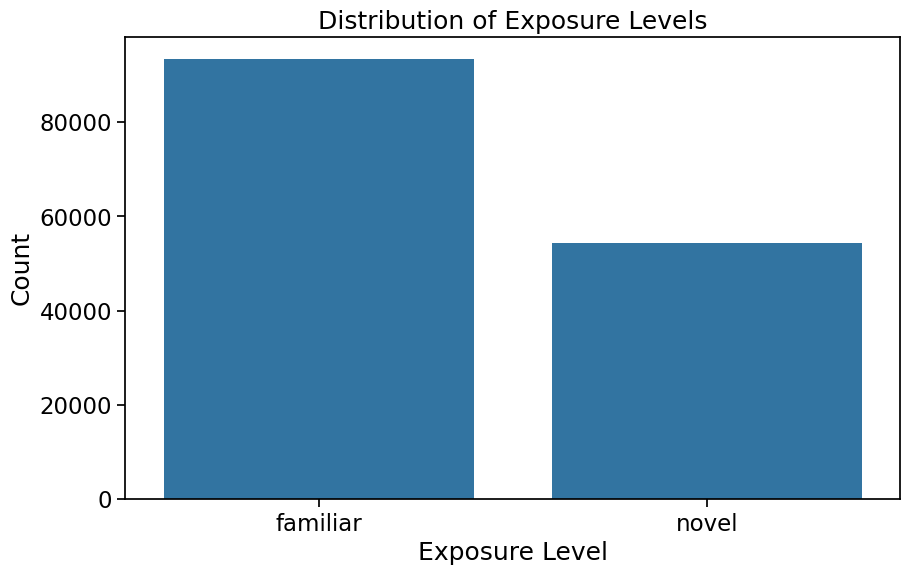

In [28]:
# Count the occurrences of each exposure level
exposure_level_counts = data['exposure_level'].value_counts()
print("Exposure level counts:\n", exposure_level_counts)

# Plot the distribution of exposure levels
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='exposure_level')
plt.xlabel('Exposure Level')
plt.ylabel('Count')
plt.title('Distribution of Exposure Levels')
plt.show()

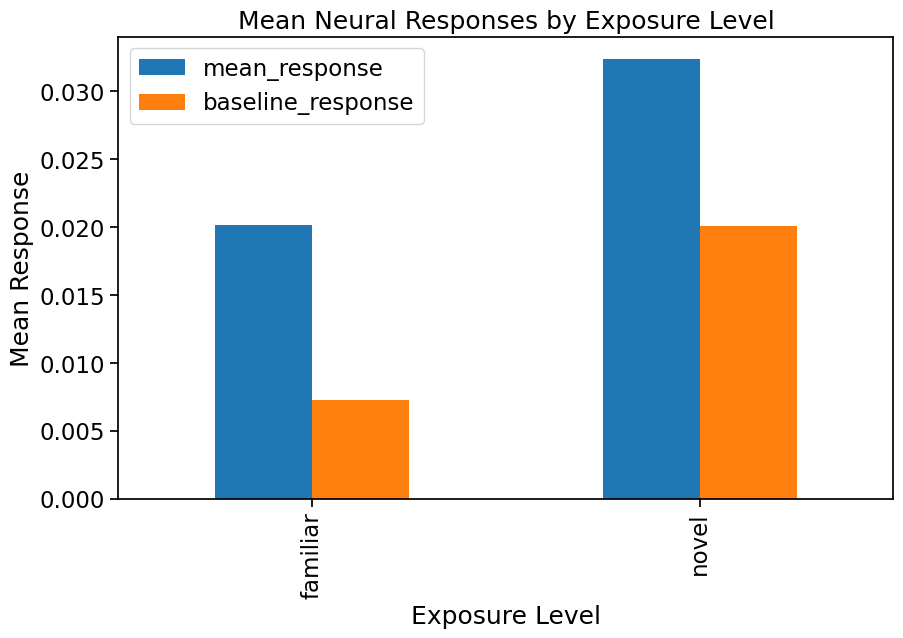

In [29]:
# Group data by exposure level and calculate mean responses
exposure_level_means = data.groupby('exposure_level')[['mean_response', 'baseline_response']].mean()

# Plot the mean responses for each exposure level
exposure_level_means.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Exposure Level')
plt.ylabel('Mean Response')
plt.title('Mean Neural Responses by Exposure Level')
plt.show()

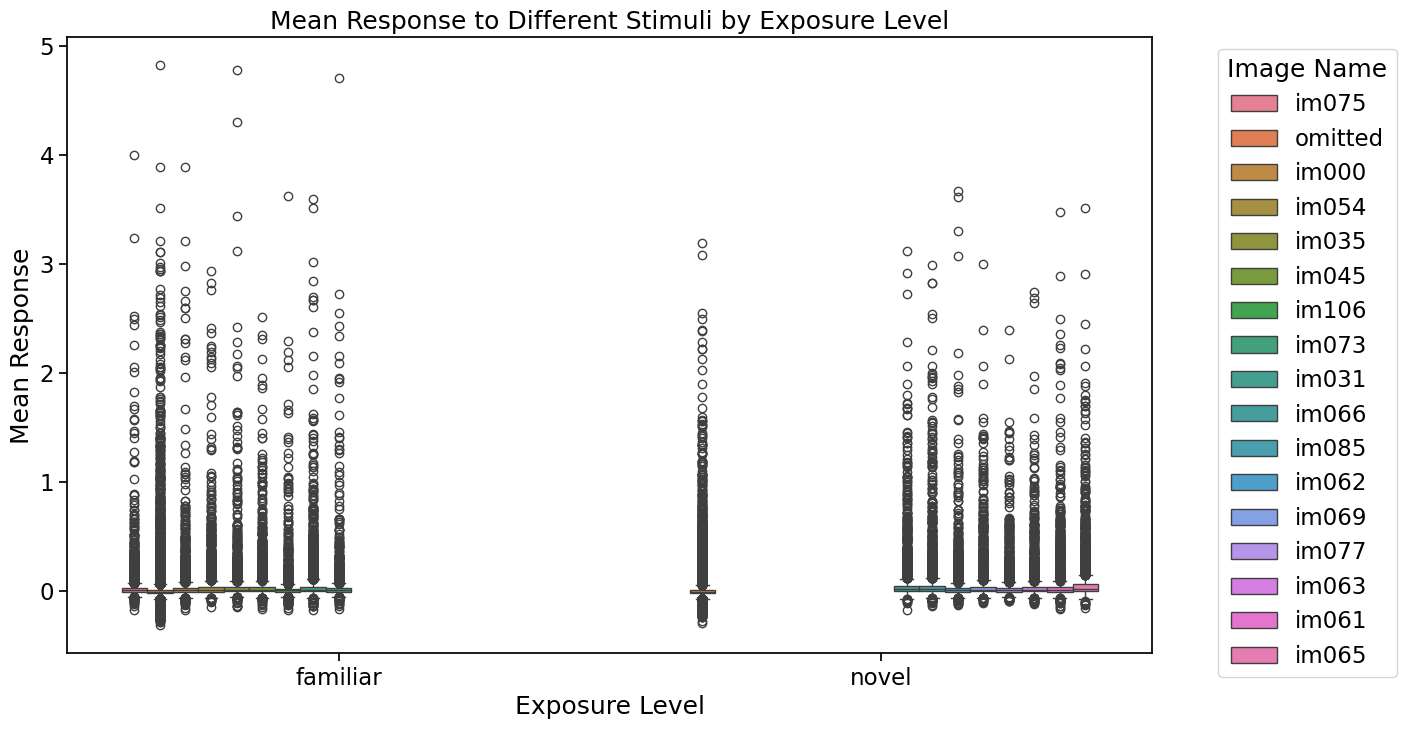

In [30]:
# Boxplot to compare responses to different stimuli across exposure levels
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='exposure_level', y='mean_response', hue='image_name')
plt.xlabel('Exposure Level')
plt.ylabel('Mean Response')
plt.title('Mean Response to Different Stimuli by Exposure Level')
plt.legend(title='Image Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

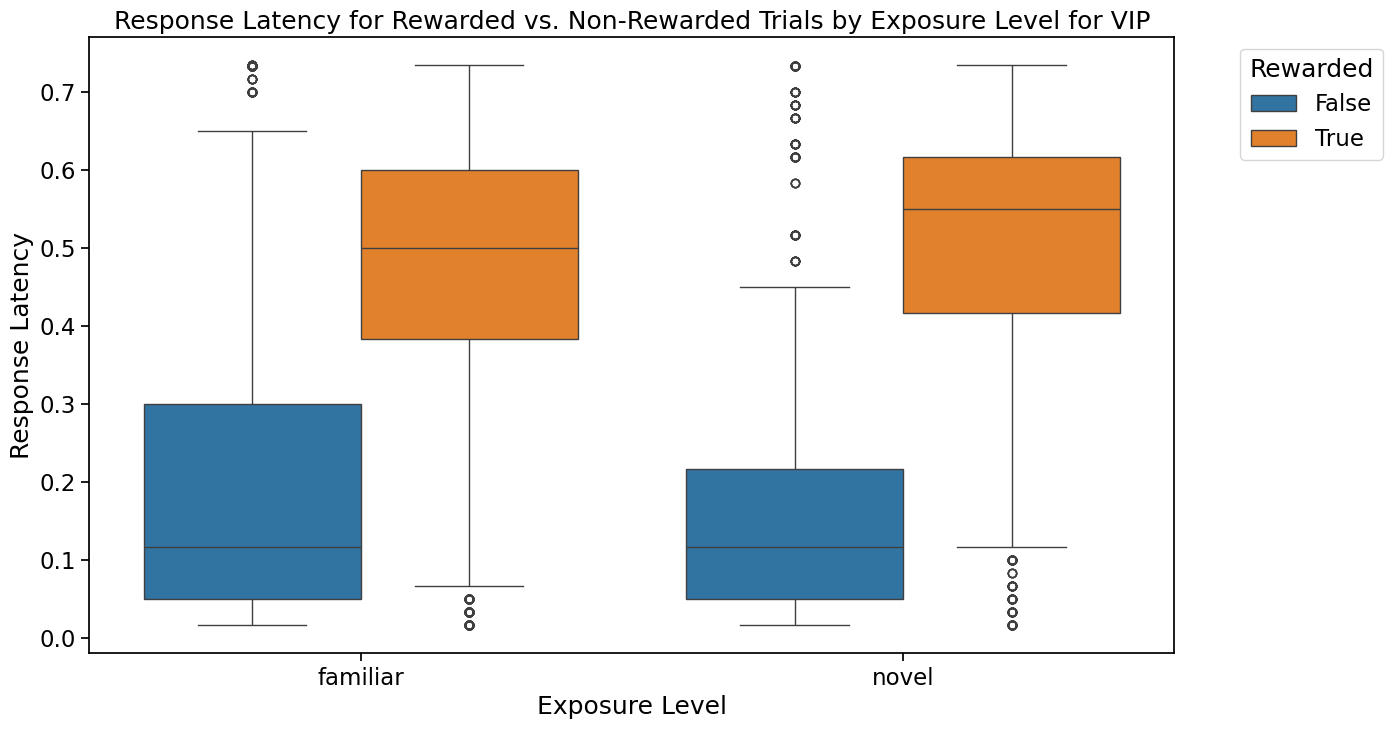

In [60]:
# Compare response latency for rewarded vs. non-rewarded trials across exposure levels
plt.figure(figsize=(14, 8))
sns.boxplot(data=vip_data, x='exposure_level', y='response_latency', hue='rewarded')
plt.xlabel('Exposure Level')
plt.ylabel('Response Latency')
plt.title('Response Latency for Rewarded vs. Non-Rewarded Trials by Exposure Level for VIP')
plt.legend(title='Rewarded', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [53]:
data['image_index'].unique()

array([2, 8, 0, 5, 7, 4, 1, 3, 6])

In [56]:
data.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'mean_response', 'baseline_response', 'image_name', 'image_index',
       'is_change', 'omitted', 'mean_running_speed', 'mean_pupil_area',
       'response_latency', 'rewarded', 'ophys_experiment_id', 'imaging_depth',
       'targeted_structure', 'cre_line', 'session_type', 'session_number',
       'mouse_id', 'ophys_session_id', 'ophys_container_id',
       'behavior_session_id', 'full_genotype', 'reporter_line', 'driver_line',
       'indicator', 'sex', 'age_in_days', 'exposure_level', 'cluster'],
      dtype='object')

In [57]:
data['exposure_level'].unique()

array(['familiar', 'novel'], dtype=object)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


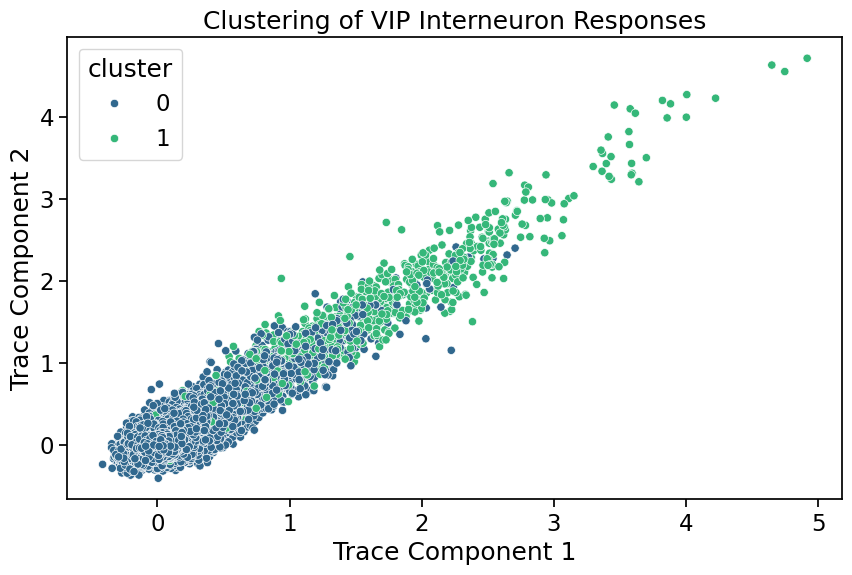

In [45]:
from sklearn.cluster import KMeans
# Prepare the data for clustering
X = np.array(data['trace'].tolist())

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['trace'].apply(lambda x: x[0]), y=data['trace'].apply(lambda x: x[1]), hue=data['cluster'], palette='viridis')
plt.title('Clustering of VIP Interneuron Responses')
plt.xlabel('Trace Component 1')
plt.ylabel('Trace Component 2')
plt.show()

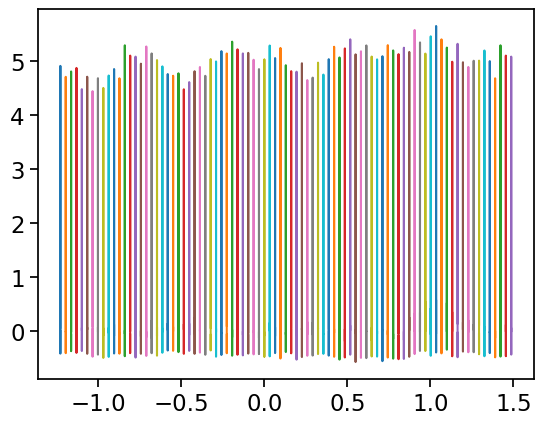

In [47]:
from sklearn.cluster import KMeans
# Prepare the data for clustering
Y = np.array(data['trace'].tolist())
X=np.array(data['trace_timestamps'].tolist())
plt.plot(X,Y)

In [48]:
data.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response', 'image_name',
       'image_index', 'is_change', 'omitted', 'mean_running_speed',
       'mean_pupil_area', 'response_latency', 'rewarded',
       'ophys_experiment_id', 'imaging_depth', 'targeted_structure',
       'cre_line', 'session_type', 'session_number', 'mouse_id',
       'ophys_session_id', 'ophys_container_id', 'behavior_session_id',
       'full_genotype', 'reporter_line', 'driver_line', 'indicator', 'sex',
       'age_in_days', 'exposure_level', 'cluster'],
      dtype='object')

In [50]:
data['trace_timestamps'] = pd.to_datetime(data['trace_timestamps'], errors='coerce')


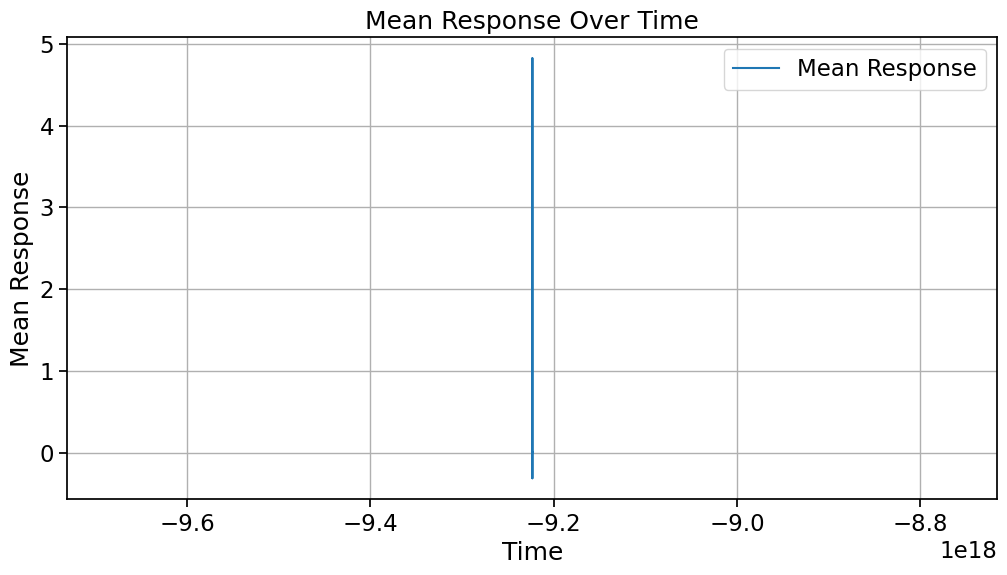

In [51]:
# Set 'trace_timestamps' as the index for time series analysis
data.set_index('trace_timestamps', inplace=True)

# Plotting time series data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['mean_response'], label='Mean Response')
plt.title('Mean Response Over Time')
plt.xlabel('Time')
plt.ylabel('Mean Response')
plt.legend()
plt.grid(True)
plt.show()

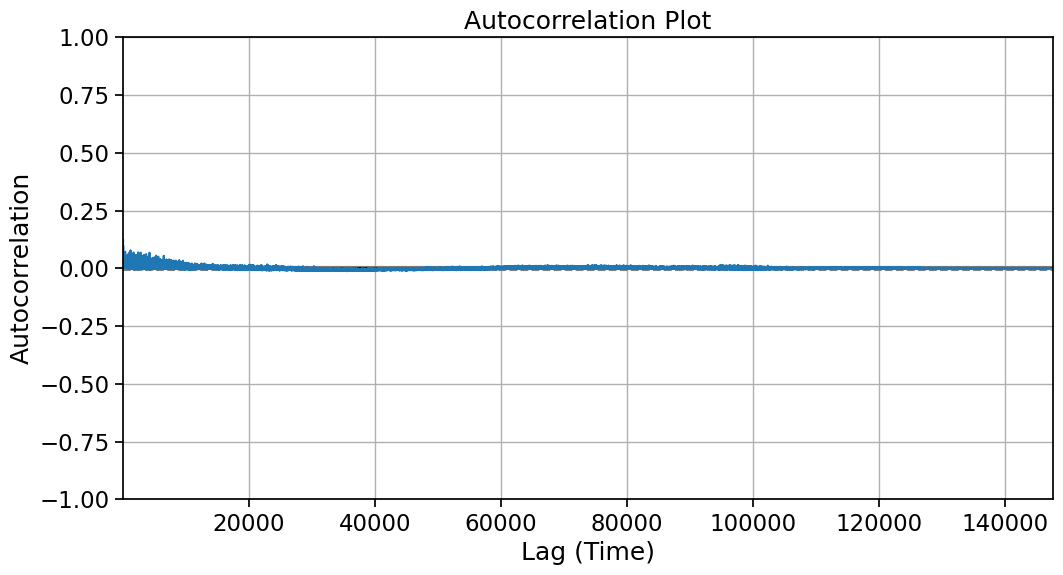

In [52]:
# Example of autocorrelation plot
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))
autocorrelation_plot(data['mean_response'])
plt.title('Autocorrelation Plot')
plt.xlabel('Lag (Time)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [42]:
# Check if 'trace' and 'trace_timestamps' columns contain strings
print(data['trace'].apply(type).unique())
print(data['trace_timestamps'].apply(type).unique())

[<class 'numpy.ndarray'>]
[<class 'numpy.ndarray'>]



##### Available data includes:
*   The cell `trace` aligned to stimulus (or omission) onset in a [-1.25, 1.5] second window around onset time
    *   Cell traces are in units of delta F/F, the change in fluorescence relative to baseline
*   The `trace_timestamps` for each trial, aligned to stimulus or omission onset
*   The `mean_response` on a given trial in a 500ms window after stimulus onset
*   The `baseline_response` on a given trial in a 500ms window before stimulus onset
*   The `image_name` for each trial. Trials where the stimulus was omitted have `image_name` = `omitted`
*   The `mean_running_speed` in a 500ms window after stimulus onset
*   The `mean_pupil_area` in a 500ms window after stimulus onset
*   The `response_latency` when the mouse licked after stimulus onset
*   Whether or not the trial was `rewarded`
*   Whether or not the trial `is_change`
*   Whether or not the trial was `omitted`

#### Cell and session level metadata includes:

*   The `stimulus_presentations_id` indicating the trial number within the session
*   The `cell_specimen_id` which is the unique identifier for each cell (note that a cell can be imaged in multiple sessions; if that's the case, the same cell_specimen_id appears in multiple sessions)
*   The `cre_line` indicating the cell type
  *   `Sst-IRES-Cre` labels SST inhibitory cells
  *   `Vip-IRES-Cre` labels VIP inhibitory cells
  *   `Slc17a7-IRES-Cre` labels excitatory cells
*   The `imaging_depth` indicating the cortical depth where the cell was located
*   The `targeted_structure` indicating the cortical area the cell was from
*   The `session_type` indicating the session order and image set
*   The `exposure_level` which tells you whether the image set was familiar or novel
*   The `mouse_id` indicating which mouse the cell came from
*   The `ophys_session_id` indicating the recording day for that trial
*   The `ophys_experiment_id` indicating which imaging plane within the session that the cell came from
*   The `ophys_container_id` which links the same imaging plane recorded across multiple sessions. Cells that are imaged across multiple sessions will have the same `cell_specimen_id`.




### Let's check what is available


In [ ]:
print('exposure_levels:', data.exposure_level.unique())

exposure_levels: ['familiar' 'novel']


In [ ]:
print('stimulus presentations can be changes:', data.is_change.unique())

stimulus presentations can be changes: [ True False]


In [ ]:
print('stimulus presentations can be omitted:', data.omitted.unique())

stimulus presentations can be omitted: [False  True]


In [ ]:
print('cre lines (cell types) included in this dataset are:', data.cre_line.unique())

cre lines (cell types) included in this dataset are: ['Sst-IRES-Cre' 'Vip-IRES-Cre']


In [ ]:
print('there are', len(data.mouse_id.unique()), 'mice in this dataset')

there are 13 mice in this dataset


In [ ]:
print('there are', len(data.ophys_session_id.unique()), 'sessions in this dataset')

there are 25 sessions in this dataset



# How are VIP and SST cells affected by stimulus novelty?

### Plot the population average change response for familiar and novel images for each cre line

Get trials where the image identity changed, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]

Plot the population average change response of SST cells for familiar and novel images

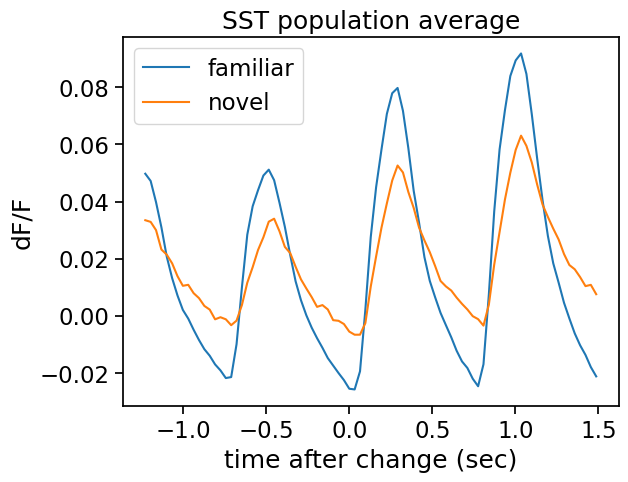

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot the population average change response of VIP cells for familiar and novel images

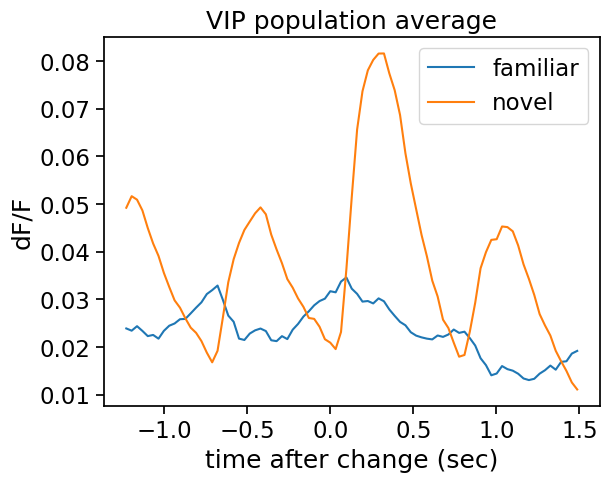

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### Can you find cells that were imaged across multiple sessions? How do single cells change depending on the image set?

In [ ]:
# which cells are in more than one session? make a list
cells_in_multiple_sessions = []
for cell_specimen_id in vip_data.cell_specimen_id.unique():
  if len(vip_data[vip_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions.append(cell_specimen_id)

print(cells_in_multiple_sessions)

[1086495458, 1086495538, 1086495170, 1086495264, 1086496225, 1086495925, 1086495377, 1086496359, 1086496472, 1086496547, 1086496681, 1086497031, 1086496844, 1086500839, 1086500898, 1086500959, 1086501038, 1086501134, 1086501280, 1086501226, 1086501454, 1086501538, 1086501601, 1086501688, 1086489847, 1086489860, 1086489891, 1086558904, 1086556416, 1086555432, 1086559188, 1086555190, 1086567589, 1086559446, 1086567897, 1086558341, 1086556696, 1086561830, 1086557997, 1086559782, 1086560048, 1086567017, 1086557082, 1086556094, 1086563032, 1086563829, 1086560926, 1086561466, 1086562430, 1086560592, 1086566230, 1086566746, 1086563384, 1086562780, 1086565528, 1086497765, 1086498401, 1086498125, 1086499101, 1086498544, 1086498699, 1086498800, 1086498889, 1086498976]


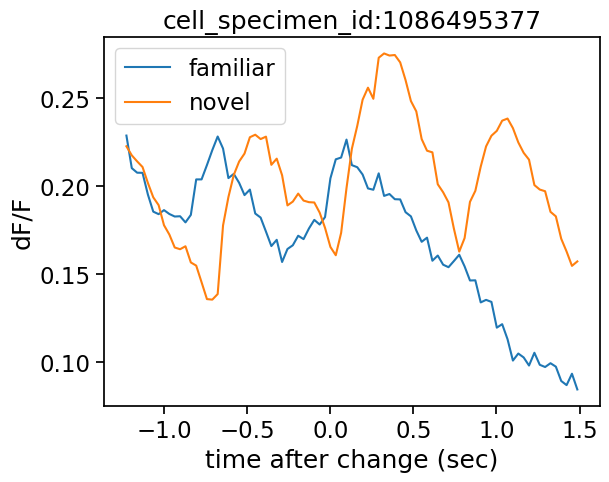

In [ ]:
# this one looks like the population average
example_cell_specimen_id = cells_in_multiple_sessions[6]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

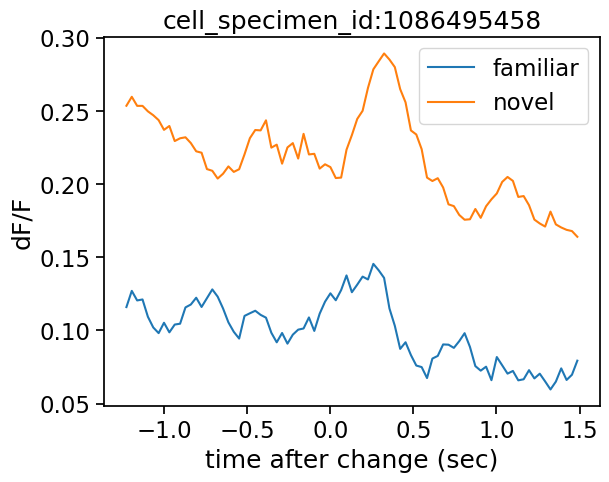

In [ ]:
# this one does not look like the population average
example_cell_specimen_id = cells_in_multiple_sessions[0]

cell_data = vip_data[vip_data.cell_specimen_id==example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### What about trial to trial variability? How does the response of a single cell vary across a session?



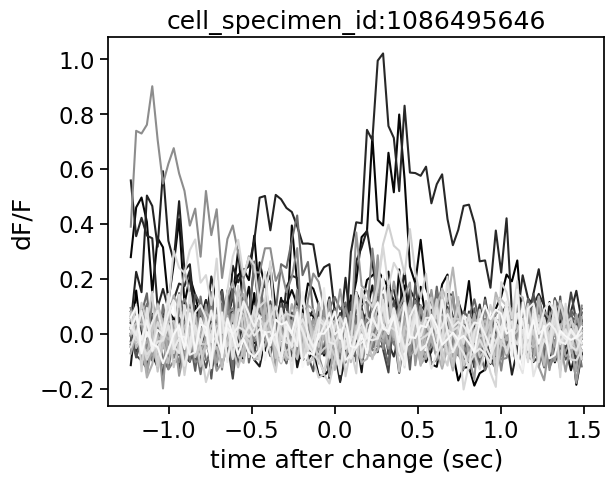

In [ ]:
# let's pick a cell from a novel image session
example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]

offset = 1 / len(cell_data.stimulus_presentations_id.unique())
color = [0, 0, 0]

for i, stimulus_presentations_id in enumerate(cell_data.stimulus_presentations_id.unique()):
  trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
  timestamps = trial_data.trace_timestamps.values[0]
  trace = trial_data.trace.values[0]
  plt.plot(timestamps, trace, color = color)
  color = [color[0] + offset, color[1] + offset, color[2] + offset]
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

# How do SST and VIP cells respond when stimuli are omitted?¶

### Plot the population average response to stimulus omission

Get trials where the stimulus was omitted, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.omitted == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.omitted == True)]

Plot the population average omission response of SST cells for familiar and novel images

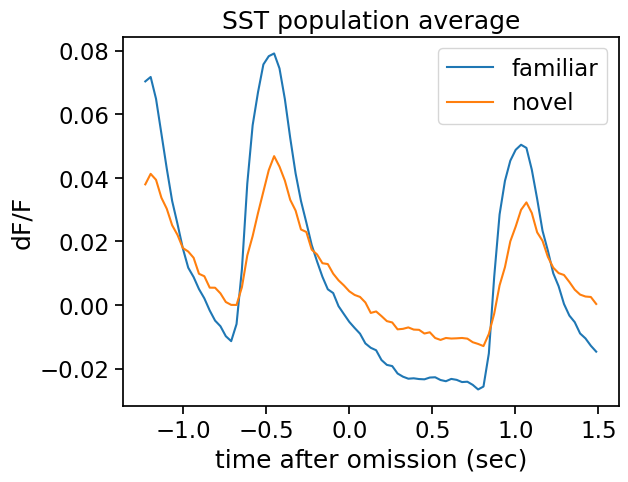

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot population average omission response of VIP cells for familiar and novel images

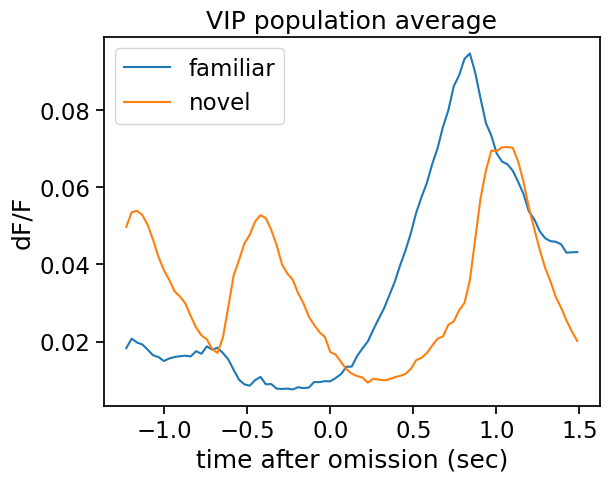

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Does the omission response correlate with behavior?

How do the dynamics of image and omission evoked activity change over time during the novel image session?

### To learn how to use the AllenSDK to access the full dataset, and see more in depth examples of how to interact with the data, check out the additional tutorials here:

https://colab.research.google.com/drive/163dPehppRK6JeHypgfB3gyaGQqKshNQc?usp=sharing

and in the 'Getting Started' section here:

https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html


